In [43]:
import os
import pandas as pd
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [44]:
os.getcwd()

'/home/kevin'

In [45]:
os.chdir('/home/kevin')

In [46]:
dataset_directory = "trafficsigns_dataset"

#Gets class names by listing directories
class_names = sorted(os.listdir(dataset_directory))  # Ensure it's sorted to match the order used by TensorFlow
print("Class names:", class_names)

#prints class name and corresponding index
print("Class names and their corresponding indices:")
for index, name in enumerate(class_names):
    print(f"Class {index}: {name}")

Class names: ['diamond', 'hex', 'round', 'square', 'triangle']
Class names and their corresponding indices:
Class 0: diamond
Class 1: hex
Class 2: round
Class 3: square
Class 4: triangle


In [47]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Setting 20% of the data for validation
)


In [48]:
# Directory where your images are stored
directory = 'trafficsigns_dataset/'

# Training generator
train_generator = datagen.flow_from_directory(
    directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

Found 2946 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [49]:
import scipy
from scipy.ndimage import gaussian_filter, binary_dilation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [50]:
#confirming shape of images
batch_size = 32
train_dataset = train_generator[0]

# Print the shapes of the images and labels
print("Images shape:", train_dataset[0].shape)
print("Labels shape:", train_dataset[1].shape)

Images shape: (32, 28, 28, 1)
Labels shape: (32, 5)


In [51]:
num_classes = 5

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4390 - loss: 1.3035 - val_accuracy: 0.5526 - val_loss: 1.2834
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.5938 - loss: 1.2957 - val_accuracy: 0.4839 - val_loss: 1.3473
Epoch 3/15


2024-05-10 00:05:37.089352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-10 00:05:37.111881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5671 - loss: 1.1064 - val_accuracy: 0.5767 - val_loss: 1.1532
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - accuracy: 0.5000 - loss: 1.1776 - val_accuracy: 0.3548 - val_loss: 1.4982
Epoch 5/15


2024-05-10 00:05:41.170697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:05:41.192588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6486 - loss: 0.9406 - val_accuracy: 0.6634 - val_loss: 0.9737
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.6875 - loss: 0.8104 - val_accuracy: 0.7742 - val_loss: 0.9204
Epoch 7/15


2024-05-10 00:05:45.559942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:05:45.590620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6834 - loss: 0.8277 - val_accuracy: 0.6875 - val_loss: 0.9407
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.8438 - loss: 0.5242 - val_accuracy: 0.6129 - val_loss: 0.9641
Epoch 9/15


2024-05-10 00:05:49.673111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:05:49.703286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7458 - loss: 0.7070 - val_accuracy: 0.6832 - val_loss: 0.8152
Epoch 10/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.8125 - loss: 0.6067 - val_accuracy: 0.6774 - val_loss: 0.9300
Epoch 11/15


2024-05-10 00:05:53.815813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:05:53.845190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7647 - loss: 0.6169 - val_accuracy: 0.7713 - val_loss: 0.6495
Epoch 12/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.7500 - loss: 0.6875 - val_accuracy: 0.8387 - val_loss: 0.5779
Epoch 13/15


2024-05-10 00:05:57.323400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:05:57.346793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8151 - loss: 0.5061 - val_accuracy: 0.7642 - val_loss: 0.7176
Epoch 14/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.7188 - loss: 0.5110 - val_accuracy: 0.7419 - val_loss: 0.6817
Epoch 15/15


2024-05-10 00:06:01.695150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:06:01.727702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8265 - loss: 0.4671 - val_accuracy: 0.7472 - val_loss: 0.6759


In [52]:
# epochs = 15
# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
# ]
# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     callbacks=callbacks,
#     validation_data=validation_generator,
# )

### plot Validation Loss and Training Loss

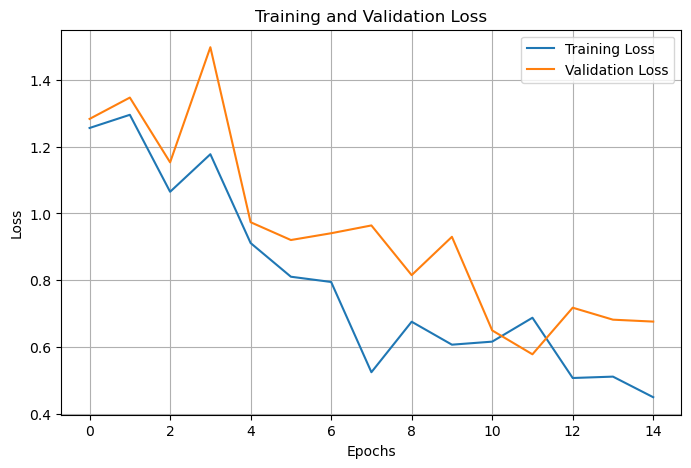

In [53]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Plot Validation Accuracy and Training Accuracy

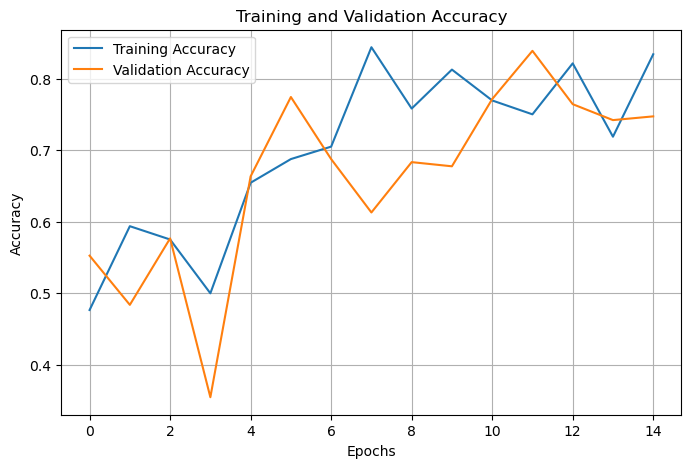

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Change 'loss' to 'accuracy'
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Change 'val_loss' to 'val_accuracy'
plt.title('Training and Validation Accuracy')  # Change title to Accuracy
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  # Change Y-axis label to Accuracy
plt.legend()
plt.grid(True)
plt.show()

### Type classification model

In [55]:
# Do not run unless using google colab
!unzip trafficsigns_dataset_withtype.zip
%ls

unzip:  cannot find or open trafficsigns_dataset_withtype.zip, trafficsigns_dataset_withtype.zip.zip or trafficsigns_dataset_withtype.zip.ZIP.
 A1.ipynb
 AA/
'Act 1_ Basic Text Preprocessing with NLTK Part I.ipynb'
'Act 1_Parsing CSV_TSV Files.ipynb'
'Act 2 _ Bikeshare Trip Data Integration.ipynb'
'Act 2_ Basic Text Preprocessing with NLTK Part II.ipynb'
'Act 2_Parsing JSON Files.ipynb'
'Act 3_ Generating Feature Vectors.ipynb'
'Act 3_Parsing XML files.ipynb'
'Act 4_Document Classification.ipynb'
'Act 5_Fun with word embeddings.ipynb'
'Act 6_ Document classification with embeddings.ipynb'
'Assignment 2-checkpoint.ipynb'
 BostonHousingPrice/
 BostonHousingPrice.zip
 BostonHousingPrice.zip:Zone.Identifier
 CIFAR10_Lab9-1/
 CIFAR10_Lab9-1.zip:Zone.Identifier
 CIFAR10_Lab9-1.zip:shield
 CIFAR_10_BATCH1/
 CIFAR_Data.csv
'Cardiotocography_Data_Set (2).csv:Zone.Identifier'
'Cardiotocography_Data_Set (2).csv:shield'
 Cardiotocography_Data_Set.csv
'Cardiotocography_Data_Set_subset (2).csv:Zone.

In [59]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd
import zipfile
with zipfile.ZipFile('./types.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

sign_type_class_names = ['rightofway','stop','bicycle','limitedtraffic','noentry','noparking','roundabout','speed','trafficdirective','traveldirection','continue',
                         'crossing','laneend','parking','giveway','warning']

import glob
image_list = []
for filepath in glob.glob('./types/*/*.png', recursive=True):
    filename = filepath.split('/')[-1]
    sign_type = filepath.split('/')[-2]
    image_list.append((filepath, sign_type))

data = pd.DataFrame(data=image_list, columns=['image_path', 'sign_type'])

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

In [60]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [61]:
reg_lambda = 0.001
OUTPUT_CLASSES = 16

model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),


    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [64]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_leNet.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet.fit(train_generator,
                                    validation_data = validation_generator,
                                    epochs=100, verbose=0)

/home/kevin/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:32: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/home/kevin/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


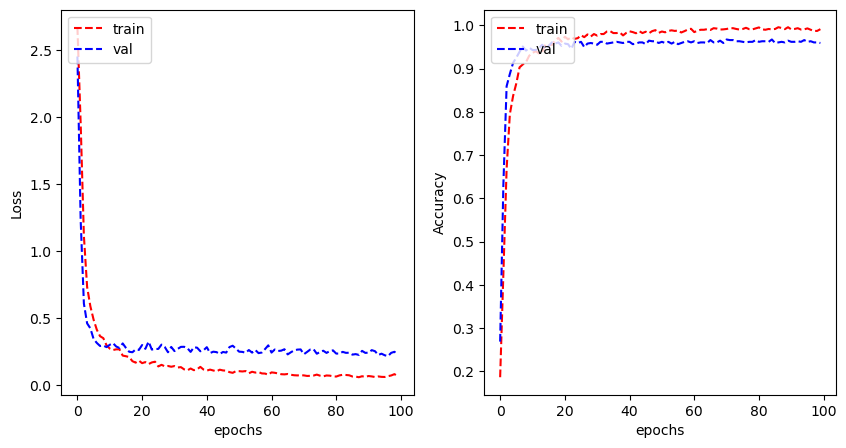

In [66]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### data Augmentation

In [67]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [69]:
model_leNet_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),


    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_leNet_aug .compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet_aug .fit(train_generator,
                                    validation_data = validation_generator,
                                    epochs=150, verbose=0)

ValueError: Unknown variable: <KerasVariable shape=(3, 3, 1, 32), dtype=float32, path=sequential_7/conv2d_14/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

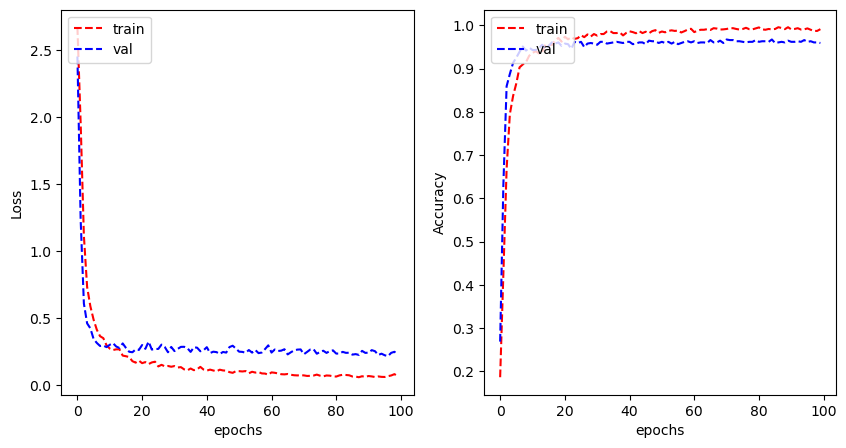

In [70]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [71]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = './',
    x_col = 'image_path',
    y_col = 'sign_type',
    target_size = (28, 28),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 740 validated image filenames belonging to 16 classes.


In [72]:
model_leNet_aug.evaluate(test_generator)

11/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.0918 - loss: 2.8285

/home/kevin/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - categorical_accuracy: 0.0957 - loss: 2.8270


[2.826213836669922, 0.09054054319858551]

### Independent Evaluation

In [ ]:
# Get image names from sign-type directories
# rw = sorted(os.listdir("trafficsigns_dataset/diamond/rightofway"))
# st = sorted(os.listdir("trafficsigns_dataset/hex/stop"))
# bc = sorted(os.listdir("trafficsigns_dataset/round/bicycle"))
# lt = sorted(os.listdir("trafficsigns_dataset/round/limitedtraffic"))
# ne = sorted(os.listdir("trafficsigns_dataset/round/noentry"))
# np = sorted(os.listdir("trafficsigns_dataset/round/noparking"))
# ra = sorted(os.listdir("trafficsigns_dataset/round/roundabout"))
# sp = sorted(os.listdir("trafficsigns_dataset/round/speed"))
# td = sorted(os.listdir("trafficsigns_dataset/round/trafficdirective"))
# trvd = sorted(os.listdir("trafficsigns_dataset/round/traveldirection"))
# ct = sorted(os.listdir("trafficsigns_dataset/square/continue"))
# cr = sorted(os.listdir("trafficsigns_dataset/square/crossing"))
# le = sorted(os.listdir("trafficsigns_dataset/square/laneend"))
# pk = sorted(os.listdir("trafficsigns_dataset/square/parking"))
# gw = sorted(os.listdir("trafficsigns_dataset/triangle/giveway"))
# wn = sorted(os.listdir("trafficsigns_dataset/triangle/warning"))

In [ ]:
# sign_type_dict = []

# for i in rw:
#   sign_type_dict.append(["trafficsigns_dataset/diamond/rightofway/" + i,"rightofway"])

# for i in st:
#   sign_type_dict.append(["trafficsigns_dataset/hex/stop/" + i,"stop"])

# for i in bc:
#   sign_type_dict.append(["trafficsigns_dataset/round/bicycle/" + i,"bicycle"])

# for i in lt:
#   sign_type_dict.append(["trafficsigns_dataset/round/limitedtraffic/" + i,"limitedtraffic"])

# for i in ne:
#   sign_type_dict.append(["trafficsigns_dataset/round/noentry/" + i,"noentry"])

# for i in np:
#   sign_type_dict.append(["trafficsigns_dataset/round/noparking/" + i,"noparking"])

# for i in ra:
#   sign_type_dict.append(["trafficsigns_dataset/round/roundabout/" + i,"roundabout"])

# for i in sp:
#   sign_type_dict.append(["trafficsigns_dataset/round/speed/" + i,"speed"])

# for i in td:
#   sign_type_dict.append(["trafficsigns_dataset/round/trafficdirective/" + i,"trafficdirective"])

# for i in trvd:
#   sign_type_dict.append(["trafficsigns_dataset/round/traveldirection/" + i,"traveldirection"])

# for i in ct:
#   sign_type_dict.append(["trafficsigns_dataset/square/continue/" + i,"continue"])

# for i in cr:
#   sign_type_dict.append(["trafficsigns_dataset/square/crossing/" + i,"crossing"])

# for i in le:
#   sign_type_dict.append(["trafficsigns_dataset/square/laneend/" + i,"laneend"])

# for i in pk:
#   sign_type_dict.append(["trafficsigns_dataset/square/parking/" + i,"parking"])

# for i in gw:
#   sign_type_dict.append(["trafficsigns_dataset/triangle/giveway/" + i,"giveway"])

# for i in wn:
#   sign_type_dict.append(["trafficsigns_dataset/triangle/warning/" + i,"warning"])

In [ ]:
# stdf = pd.DataFrame(data=sign_type_dict, columns=['imgPath', 'class'])

# stdf.head()

In [ ]:
# train_data, test_data = train_test_split(stdf, test_size=0.2, random_state=42)
# train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

In [ ]:
# def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
#     plt.figure(figsize=(10,5))

#     plt.subplot(1,2,1)
#     plt.plot(train_loss, 'r--')
#     plt.plot(val_loss, 'b--')
#     plt.xlabel("epochs")
#     plt.ylabel("Loss")
#     plt.legend(['train', 'val'], loc='upper left')

#     plt.subplot(1,2,2)
#     plt.plot(train_metric, 'r--')
#     plt.plot(val_metric, 'b--')
#     plt.xlabel("epochs")
#     plt.ylabel(metric_name)
#     plt.legend(['train', 'val'], loc='upper left')

#     plt.show()

In [ ]:
# INPUT_DIM = (28,28,3)
# HIDDEN_LAYER_DIM = 256
# OUTPUT_CLASSES = 16

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=INPUT_DIM),
#     tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
#     tf.keras.layers.Dense(OUTPUT_CLASSES)
# ])

In [ ]:
# model.summary()

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# model.compile(optimizer='SGD',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['categorical_accuracy'])

In [ ]:
# train_data['class'] = train_data['class'].astype('str')
# val_data['class'] = val_data['class'].astype('str')

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# batch_size = 28

# train_generator = train_datagen.flow_from_dataframe(
#         dataframe=train_data,
#         directory='./',
#         x_col="imgPath",
#         y_col="class",
#         target_size=(28, 28),
#         batch_size=batch_size,
#         class_mode='categorical')

# validation_generator = val_datagen.flow_from_dataframe(
#         dataframe=test_data,
#         directory='./',
#         x_col="imgPath",
#         y_col="class",
#         target_size=(28, 28),
#         batch_size=batch_size,
#         class_mode='categorical')

In [ ]:
# history = model.fit(train_generator, validation_data = validation_generator, epochs=15, verbose=0)

In [ ]:
# plot_learning_curve(history.history['loss'], history.history['val_loss'],
#                     history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
#                     metric_name='Accuracy')

In [ ]:
# test_data['class'] = test_data['class'].astype('str')

# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# batch_size = 1

# test_generator = test_datagen.flow_from_dataframe(
#         dataframe=test_data,
#         directory='./',
#         x_col="imgPath",
#         y_col="class",
#         target_size=(28, 28),
#         batch_size=batch_size,
#         class_mode='categorical')

In [ ]:
# model.evaluate(test_generator)

In [ ]:
# label_names = {'rightofway' : 0, 'stop' : 1, 'bicycle' : 2, 'limitedtraffic' : 3, 'noentry' : 4, 'noparking' : 5, 'roundabout' : 6, 'speed' : 7, 'trafficdirective' : 8, 'traveldirection' : 9,
#                'continue' : 10, 'crossing' : 11, 'laneend' : 12, 'parking' : 13, 'giveway' : 14, 'warning' : 15}

In [ ]:
# d_inv = {v: k for k, v in label_names.items()}
# plt.figure(figsize=(16,4))
# batches = 0
# for x,y in test_generator:
#         batches = batches + 1
#         y_hat = model.predict(x, verbose=0)
#         x = np.squeeze(x)
#         if batches < 5:
#             plt.subplot(1,5,batches)
#             plt.imshow(x)
#             plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))

#         else:
#             break

#         plt.axis('off')